In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt


from sklearn import decomposition
from sklearn import datasets
%matplotlib inline

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
        
        if i in [2,4]:
            sample_n = 7500
            
        if i == 3:
            sample_n = 8500
        elif i == 0:
            sample_n = 8000
        elif i == 1:
            sample_n = 8500
            
        else:
            sample_n = 5000
        
        curr_num_sub = curr_num.sample(n=sample_n, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

#RUN PCA
pca = decomposition.PCA(n_components=45)
pca.fit(X)
X_new = pca.transform(X)
#print("new shapes:",X.shape,X_new.shape)
X = X_new
# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(8500, 55)
2:(5000, 55)
3:(8500, 55)
4:(5000, 55)
5:(5000, 55)
(37000, 55)
[0. 1. 2. 3. 4. 5.]
(37000, 51) (37000, 6)
(29600, 45) (3700, 45) (3700, 45)


In [6]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-06-03 18:05:52.067846: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-03 18:05:52.067914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-06-03 18:05:52.070125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.13439189189189188
0: 3978
1: 0.22797297297297298
1: 6748
2: 0.13577702702702701
2: 4019
3: 0.23087837837837838
3: 6834
4: 0.1347635135135135
4: 3989
5: 0.1362162162162162
5: 4032

TEST DISTRIBUTION
0: 0.1437837837837838
1: 0.2308108108108108
2: 0.1308108108108108
3: 0.21945945945945947
4: 0.1362162162162162
5: 0.13891891891891892


In [7]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.31810256 0.53960685 0.32138114 0.54648388 0.31898218 0.32242069]
[3.143640229572653, 1.8532010719087155, 3.111570249624288, 1.8298801336318424, 3.134971379603914, 3.1015379050694474]


In [8]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [9]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (15*2), 15, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (15*2), 15, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(15, 3)
    reshaped_inputs = keras.layers.Reshape((15, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(15, 3)
    landmarks = keras.layers.Reshape((15, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [11]:
# Define the model
inputs = tf.keras.Input(shape=(45))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 15, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 15, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 15, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1848/1850 [============================>.] - ETA: 0s - loss: 0.2226 - tp: 2880.0000 - fp: 488.0000 - tn: 147352.0000 - fn: 26688.0000 - accuracy: 0.8468 - precision: 0.8551 - recall: 0.0974 - auc: 0.8458 - prc: 0.5381
Epoch 1: val_loss improved from inf to 0.17035, saving model to weights.best.onlyfocalloss


2022-06-03 18:06:23.123232: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 11s 4ms/step - loss: 0.2226 - tp: 2886.0000 - fp: 488.0000 - tn: 147512.0000 - fn: 26714.0000 - accuracy: 0.8468 - precision: 0.8554 - recall: 0.0975 - auc: 0.8458 - prc: 0.5383 - val_loss: 0.1703 - val_tp: 456.0000 - val_fp: 28.0000 - val_tn: 18472.0000 - val_fn: 3244.0000 - val_accuracy: 0.8526 - val_precision: 0.9421 - val_recall: 0.1232 - val_auc: 0.9124 - val_prc: 0.6954
Epoch 2/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.1750 - tp: 5134.0000 - fp: 697.0000 - tn: 146823.0000 - fn: 24370.0000 - accuracy: 0.8584 - precision: 0.8805 - recall: 0.1740 - auc: 0.9043 - prc: 0.6704
Epoch 2: val_loss improved from 0.17035 to 0.14942, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 6s 3ms/step - loss: 0.1750 - tp: 5161.0000 - fp: 702.0000 - tn: 1472

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 7s 4ms/step - loss: 0.1237 - tp: 13356.0000 - fp: 1291.0000 - tn: 146709.0000 - fn: 16244.0000 - accuracy: 0.9013 - precision: 0.9119 - recall: 0.4512 - auc: 0.9549 - prc: 0.8303 - val_loss: 0.1003 - val_tp: 1801.0000 - val_fp: 62.0000 - val_tn: 18438.0000 - val_fn: 1899.0000 - val_accuracy: 0.9117 - val_precision: 0.9667 - val_recall: 0.4868 - val_auc: 0.9721 - val_prc: 0.8932
Epoch 12/200
1847/1850 [============================>.] - ETA: 0s - loss: 0.1239 - tp: 13324.0000 - fp: 1257.0000 - tn: 146503.0000 - fn: 16228.0000 - accuracy: 0.9014 - precision: 0.9138 - recall: 0.4509 - auc: 0.9550 - prc: 0.8309
Epoch 12: val_loss improved from 0.10027 to 0.09877, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 7s 4ms/step - loss: 0.1239 - tp: 13350.0000 - fp: 1258.0000 - 

1843/1850 [============================>.] - ETA: 0s - loss: 0.1159 - tp: 14762.0000 - fp: 1238.0000 - tn: 146202.0000 - fn: 14726.0000 - accuracy: 0.9098 - precision: 0.9226 - recall: 0.5006 - auc: 0.9610 - prc: 0.8525
Epoch 22: val_loss did not improve from 0.09096
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1159 - tp: 14814.0000 - fp: 1241.0000 - tn: 146759.0000 - fn: 14786.0000 - accuracy: 0.9098 - precision: 0.9227 - recall: 0.5005 - auc: 0.9610 - prc: 0.8526 - val_loss: 0.0912 - val_tp: 1975.0000 - val_fp: 60.0000 - val_tn: 18440.0000 - val_fn: 1725.0000 - val_accuracy: 0.9196 - val_precision: 0.9705 - val_recall: 0.5338 - val_auc: 0.9774 - val_prc: 0.9108
Epoch 23/200
1836/1850 [============================>.] - ETA: 0s - loss: 0.1139 - tp: 14986.0000 - fp: 1278.0000 - tn: 145602.0000 - fn: 14390.0000 - accuracy: 0.9111 - precision: 0.9214 - recall: 0.5101 - auc: 0.9623 - prc: 0.8565
Epoch 23: val_loss did not improve from 0.09096
1850/1850 [==============

Epoch 33/200
1829/1850 [============================>.] - ETA: 0s - loss: 0.1102 - tp: 15639.0000 - fp: 1333.0000 - tn: 144987.0000 - fn: 13625.0000 - accuracy: 0.9148 - precision: 0.9215 - recall: 0.5344 - auc: 0.9649 - prc: 0.8656
Epoch 33: val_loss did not improve from 0.08396
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1103 - tp: 15795.0000 - fp: 1346.0000 - tn: 146654.0000 - fn: 13805.0000 - accuracy: 0.9147 - precision: 0.9215 - recall: 0.5336 - auc: 0.9648 - prc: 0.8653 - val_loss: 0.0889 - val_tp: 2086.0000 - val_fp: 93.0000 - val_tn: 18407.0000 - val_fn: 1614.0000 - val_accuracy: 0.9231 - val_precision: 0.9573 - val_recall: 0.5638 - val_auc: 0.9783 - val_prc: 0.9128
Epoch 34/200
1835/1850 [============================>.] - ETA: 0s - loss: 0.1112 - tp: 15607.0000 - fp: 1282.0000 - tn: 145518.0000 - fn: 13753.0000 - accuracy: 0.9147 - precision: 0.9241 - recall: 0.5316 - auc: 0.9646 - prc: 0.8647
Epoch 34: val_loss did not improve from 0.08396
1850/1850 [=

1830/1850 [============================>.] - ETA: 0s - loss: 0.1088 - tp: 15908.0000 - fp: 1306.0000 - tn: 145094.0000 - fn: 13372.0000 - accuracy: 0.9165 - precision: 0.9241 - recall: 0.5433 - auc: 0.9665 - prc: 0.8710
Epoch 44: val_loss improved from 0.08242 to 0.08073, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 7s 4ms/step - loss: 0.1088 - tp: 16077.0000 - fp: 1322.0000 - tn: 146678.0000 - fn: 13523.0000 - accuracy: 0.9164 - precision: 0.9240 - recall: 0.5431 - auc: 0.9664 - prc: 0.8708 - val_loss: 0.0807 - val_tp: 2155.0000 - val_fp: 49.0000 - val_tn: 18451.0000 - val_fn: 1545.0000 - val_accuracy: 0.9282 - val_precision: 0.9778 - val_recall: 0.5824 - val_auc: 0.9830 - val_prc: 0.9316
Epoch 45/200
1833/1850 [============================>.] - ETA: 0s - loss: 0.1095 - tp: 15883.0000 - fp: 1292.0000 - tn: 145348.0000 - fn: 13445.0000 - accuracy: 0.9163 - precision: 0.9248 -

1830/1850 [============================>.] - ETA: 0s - loss: 0.1066 - tp: 16410.0000 - fp: 1245.0000 - tn: 145155.0000 - fn: 12870.0000 - accuracy: 0.9197 - precision: 0.9295 - recall: 0.5605 - auc: 0.9677 - prc: 0.8771
Epoch 55: val_loss did not improve from 0.07947
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1067 - tp: 16577.0000 - fp: 1261.0000 - tn: 146739.0000 - fn: 13023.0000 - accuracy: 0.9196 - precision: 0.9293 - recall: 0.5600 - auc: 0.9677 - prc: 0.8769 - val_loss: 0.0841 - val_tp: 2179.0000 - val_fp: 85.0000 - val_tn: 18415.0000 - val_fn: 1521.0000 - val_accuracy: 0.9277 - val_precision: 0.9625 - val_recall: 0.5889 - val_auc: 0.9806 - val_prc: 0.9223
Epoch 56/200
1843/1850 [============================>.] - ETA: 0s - loss: 0.1057 - tp: 16460.0000 - fp: 1354.0000 - tn: 146086.0000 - fn: 13028.0000 - accuracy: 0.9187 - precision: 0.9240 - recall: 0.5582 - auc: 0.9679 - prc: 0.8769
Epoch 56: val_loss improved from 0.07947 to 0.07934, saving model to weig

1841/1850 [============================>.] - ETA: 0s - loss: 0.1065 - tp: 16586.0000 - fp: 1381.0000 - tn: 145899.0000 - fn: 12870.0000 - accuracy: 0.9194 - precision: 0.9231 - recall: 0.5631 - auc: 0.9680 - prc: 0.8770
Epoch 66: val_loss did not improve from 0.07743
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1068 - tp: 16668.0000 - fp: 1386.0000 - tn: 146614.0000 - fn: 12932.0000 - accuracy: 0.9194 - precision: 0.9232 - recall: 0.5631 - auc: 0.9680 - prc: 0.8768 - val_loss: 0.0778 - val_tp: 2296.0000 - val_fp: 76.0000 - val_tn: 18424.0000 - val_fn: 1404.0000 - val_accuracy: 0.9333 - val_precision: 0.9680 - val_recall: 0.6205 - val_auc: 0.9839 - val_prc: 0.9347
Epoch 67/200
1848/1850 [============================>.] - ETA: 0s - loss: 0.1066 - tp: 16556.0000 - fp: 1362.0000 - tn: 146478.0000 - fn: 13012.0000 - accuracy: 0.9190 - precision: 0.9240 - recall: 0.5599 - auc: 0.9681 - prc: 0.8767
Epoch 67: val_loss did not improve from 0.07743
1850/1850 [==============

1841/1850 [============================>.] - ETA: 0s - loss: 0.1057 - tp: 16666.0000 - fp: 1344.0000 - tn: 145936.0000 - fn: 12790.0000 - accuracy: 0.9200 - precision: 0.9254 - recall: 0.5658 - auc: 0.9692 - prc: 0.8803
Epoch 77: val_loss did not improve from 0.07570
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1057 - tp: 16754.0000 - fp: 1353.0000 - tn: 146647.0000 - fn: 12846.0000 - accuracy: 0.9201 - precision: 0.9253 - recall: 0.5660 - auc: 0.9692 - prc: 0.8804 - val_loss: 0.0786 - val_tp: 2226.0000 - val_fp: 69.0000 - val_tn: 18431.0000 - val_fn: 1474.0000 - val_accuracy: 0.9305 - val_precision: 0.9699 - val_recall: 0.6016 - val_auc: 0.9839 - val_prc: 0.9345
Epoch 78/200
1844/1850 [============================>.] - ETA: 0s - loss: 0.1039 - tp: 16962.0000 - fp: 1380.0000 - tn: 146140.0000 - fn: 12542.0000 - accuracy: 0.9214 - precision: 0.9248 - recall: 0.5749 - auc: 0.9697 - prc: 0.8830
Epoch 78: val_loss did not improve from 0.07570
1850/1850 [==============

Epoch 89/200
1834/1850 [============================>.] - ETA: 0s - loss: 0.1022 - tp: 17156.0000 - fp: 1344.0000 - tn: 145376.0000 - fn: 12188.0000 - accuracy: 0.9231 - precision: 0.9274 - recall: 0.5847 - auc: 0.9708 - prc: 0.8865
Epoch 89: val_loss did not improve from 0.07545
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1021 - tp: 17312.0000 - fp: 1350.0000 - tn: 146650.0000 - fn: 12288.0000 - accuracy: 0.9232 - precision: 0.9277 - recall: 0.5849 - auc: 0.9708 - prc: 0.8867 - val_loss: 0.0756 - val_tp: 2264.0000 - val_fp: 43.0000 - val_tn: 18457.0000 - val_fn: 1436.0000 - val_accuracy: 0.9334 - val_precision: 0.9814 - val_recall: 0.6119 - val_auc: 0.9854 - val_prc: 0.9409
Epoch 90/200
1837/1850 [============================>.] - ETA: 0s - loss: 0.1020 - tp: 17018.0000 - fp: 1325.0000 - tn: 145635.0000 - fn: 12374.0000 - accuracy: 0.9223 - precision: 0.9278 - recall: 0.5790 - auc: 0.9706 - prc: 0.8860
Epoch 90: val_loss did not improve from 0.07545
1850/1850 [=

1831/1850 [============================>.] - ETA: 0s - loss: 0.1025 - tp: 16899.0000 - fp: 1322.0000 - tn: 145158.0000 - fn: 12397.0000 - accuracy: 0.9220 - precision: 0.9274 - recall: 0.5768 - auc: 0.9704 - prc: 0.8854
Epoch 100: val_loss did not improve from 0.07302
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1025 - tp: 17092.0000 - fp: 1339.0000 - tn: 146661.0000 - fn: 12508.0000 - accuracy: 0.9220 - precision: 0.9274 - recall: 0.5774 - auc: 0.9705 - prc: 0.8855 - val_loss: 0.0768 - val_tp: 2240.0000 - val_fp: 53.0000 - val_tn: 18447.0000 - val_fn: 1460.0000 - val_accuracy: 0.9318 - val_precision: 0.9769 - val_recall: 0.6054 - val_auc: 0.9850 - val_prc: 0.9384
Epoch 101/200
1833/1850 [============================>.] - ETA: 0s - loss: 0.1026 - tp: 16937.0000 - fp: 1309.0000 - tn: 145331.0000 - fn: 12391.0000 - accuracy: 0.9221 - precision: 0.9283 - recall: 0.5775 - auc: 0.9706 - prc: 0.8857
Epoch 101: val_loss did not improve from 0.07302
1850/1850 [===========

Epoch 112/200
1832/1850 [============================>.] - ETA: 0s - loss: 0.1027 - tp: 17065.0000 - fp: 1291.0000 - tn: 145269.0000 - fn: 12247.0000 - accuracy: 0.9230 - precision: 0.9297 - recall: 0.5822 - auc: 0.9708 - prc: 0.8865
Epoch 112: val_loss did not improve from 0.07302
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1027 - tp: 17220.0000 - fp: 1303.0000 - tn: 146697.0000 - fn: 12380.0000 - accuracy: 0.9230 - precision: 0.9297 - recall: 0.5818 - auc: 0.9707 - prc: 0.8864 - val_loss: 0.0758 - val_tp: 2183.0000 - val_fp: 43.0000 - val_tn: 18457.0000 - val_fn: 1517.0000 - val_accuracy: 0.9297 - val_precision: 0.9807 - val_recall: 0.5900 - val_auc: 0.9858 - val_prc: 0.9423
Epoch 113/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.1016 - tp: 17322.0000 - fp: 1334.0000 - tn: 146266.0000 - fn: 12198.0000 - accuracy: 0.9236 - precision: 0.9285 - recall: 0.5868 - auc: 0.9712 - prc: 0.8883
Epoch 113: val_loss improved from 0.07302 to 0.07198, sav

1846/1850 [============================>.] - ETA: 0s - loss: 0.1015 - tp: 17575.0000 - fp: 1382.0000 - tn: 146298.0000 - fn: 11961.0000 - accuracy: 0.9247 - precision: 0.9271 - recall: 0.5950 - auc: 0.9720 - prc: 0.8906
Epoch 123: val_loss did not improve from 0.07120
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1015 - tp: 17612.0000 - fp: 1384.0000 - tn: 146616.0000 - fn: 11988.0000 - accuracy: 0.9247 - precision: 0.9271 - recall: 0.5950 - auc: 0.9720 - prc: 0.8906 - val_loss: 0.0756 - val_tp: 2274.0000 - val_fp: 65.0000 - val_tn: 18435.0000 - val_fn: 1426.0000 - val_accuracy: 0.9328 - val_precision: 0.9722 - val_recall: 0.6146 - val_auc: 0.9857 - val_prc: 0.9403
Epoch 124/200
1833/1850 [============================>.] - ETA: 0s - loss: 0.1007 - tp: 17256.0000 - fp: 1323.0000 - tn: 145317.0000 - fn: 12072.0000 - accuracy: 0.9239 - precision: 0.9288 - recall: 0.5884 - auc: 0.9717 - prc: 0.8905
Epoch 124: val_loss did not improve from 0.07120
1850/1850 [===========

Epoch 135/200
1848/1850 [============================>.] - ETA: 0s - loss: 0.1019 - tp: 17370.0000 - fp: 1290.0000 - tn: 146550.0000 - fn: 12198.0000 - accuracy: 0.9240 - precision: 0.9309 - recall: 0.5875 - auc: 0.9710 - prc: 0.8881
Epoch 135: val_loss did not improve from 0.07100
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1018 - tp: 17394.0000 - fp: 1290.0000 - tn: 146710.0000 - fn: 12206.0000 - accuracy: 0.9240 - precision: 0.9310 - recall: 0.5876 - auc: 0.9710 - prc: 0.8882 - val_loss: 0.0723 - val_tp: 2378.0000 - val_fp: 55.0000 - val_tn: 18445.0000 - val_fn: 1322.0000 - val_accuracy: 0.9380 - val_precision: 0.9774 - val_recall: 0.6427 - val_auc: 0.9867 - val_prc: 0.9458
Epoch 136/200
1829/1850 [============================>.] - ETA: 0s - loss: 0.0995 - tp: 17381.0000 - fp: 1309.0000 - tn: 145011.0000 - fn: 11883.0000 - accuracy: 0.9249 - precision: 0.9300 - recall: 0.5939 - auc: 0.9725 - prc: 0.8930
Epoch 136: val_loss did not improve from 0.07100
1850/185

1842/1850 [============================>.] - ETA: 0s - loss: 0.0997 - tp: 17594.0000 - fp: 1323.0000 - tn: 146037.0000 - fn: 11878.0000 - accuracy: 0.9253 - precision: 0.9301 - recall: 0.5970 - auc: 0.9726 - prc: 0.8931
Epoch 146: val_loss did not improve from 0.07060
1850/1850 [==============================] - 5s 3ms/step - loss: 0.0997 - tp: 17669.0000 - fp: 1331.0000 - tn: 146669.0000 - fn: 11931.0000 - accuracy: 0.9253 - precision: 0.9299 - recall: 0.5969 - auc: 0.9726 - prc: 0.8930 - val_loss: 0.0722 - val_tp: 2335.0000 - val_fp: 55.0000 - val_tn: 18445.0000 - val_fn: 1365.0000 - val_accuracy: 0.9360 - val_precision: 0.9770 - val_recall: 0.6311 - val_auc: 0.9869 - val_prc: 0.9476
Epoch 147/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0995 - tp: 17711.0000 - fp: 1344.0000 - tn: 146256.0000 - fn: 11809.0000 - accuracy: 0.9257 - precision: 0.9295 - recall: 0.6000 - auc: 0.9724 - prc: 0.8938
Epoch 147: val_loss did not improve from 0.07060
1850/1850 [===========

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
1850/1850 [==============================] - 7s 4ms/step - loss: 0.0985 - tp: 17852.0000 - fp: 1390.0000 - tn: 146610.0000 - fn: 11748.0000 - accuracy: 0.9260 - precision: 0.9278 - recall: 0.6031 - auc: 0.9729 - prc: 0.8943 - val_loss: 0.0703 - val_tp: 2377.0000 - val_fp: 60.0000 - val_tn: 18440.0000 - val_fn: 1323.0000 - val_accuracy: 0.9377 - val_precision: 0.9754 - val_recall: 0.6424 - val_auc: 0.9875 - val_prc: 0.9489
Epoch 158/200
1842/1850 [============================>.] - ETA: 0s - loss: 0.1006 - tp: 17447.0000 - fp: 1351.0000 - tn: 146009.0000 - fn: 12025.0000 - accuracy: 0.9244 - precision: 0.9281 - recall: 0.5920 - auc: 0.9718 - prc: 0.8913
Epoch 158: val_loss did not improve from 0.07035
1850/1850 [==============================] - 5s 3ms/step - loss: 0.1006 - tp: 17521.0000 - fp: 1357.0000 - tn: 146643.0000 - fn: 12079.0000 - accuracy: 0.9243 - precision: 0.9281 - recall: 0.5919 - auc: 0.9718 - prc: 0.891

Epoch 169/200
1831/1850 [============================>.] - ETA: 0s - loss: 0.0991 - tp: 17515.0000 - fp: 1294.0000 - tn: 145186.0000 - fn: 11781.0000 - accuracy: 0.9256 - precision: 0.9312 - recall: 0.5979 - auc: 0.9725 - prc: 0.8941
Epoch 169: val_loss did not improve from 0.06945
1850/1850 [==============================] - 5s 3ms/step - loss: 0.0992 - tp: 17696.0000 - fp: 1307.0000 - tn: 146693.0000 - fn: 11904.0000 - accuracy: 0.9256 - precision: 0.9312 - recall: 0.5978 - auc: 0.9724 - prc: 0.8939 - val_loss: 0.0702 - val_tp: 2439.0000 - val_fp: 66.0000 - val_tn: 18434.0000 - val_fn: 1261.0000 - val_accuracy: 0.9402 - val_precision: 0.9737 - val_recall: 0.6592 - val_auc: 0.9874 - val_prc: 0.9474
Epoch 170/200
1845/1850 [============================>.] - ETA: 0s - loss: 0.0999 - tp: 17734.0000 - fp: 1334.0000 - tn: 146266.0000 - fn: 11786.0000 - accuracy: 0.9259 - precision: 0.9300 - recall: 0.6007 - auc: 0.9725 - prc: 0.8938
Epoch 170: val_loss did not improve from 0.06945
1850/185

Epoch 180/200
1847/1850 [============================>.] - ETA: 0s - loss: 0.0994 - tp: 17853.0000 - fp: 1346.0000 - tn: 146414.0000 - fn: 11699.0000 - accuracy: 0.9264 - precision: 0.9299 - recall: 0.6041 - auc: 0.9731 - prc: 0.8954
Epoch 180: val_loss did not improve from 0.06881
1850/1850 [==============================] - 5s 3ms/step - loss: 0.0994 - tp: 17883.0000 - fp: 1349.0000 - tn: 146651.0000 - fn: 11717.0000 - accuracy: 0.9264 - precision: 0.9299 - recall: 0.6042 - auc: 0.9731 - prc: 0.8954 - val_loss: 0.0689 - val_tp: 2452.0000 - val_fp: 61.0000 - val_tn: 18439.0000 - val_fn: 1248.0000 - val_accuracy: 0.9410 - val_precision: 0.9757 - val_recall: 0.6627 - val_auc: 0.9880 - val_prc: 0.9510
Epoch 181/200
1850/1850 [==============================] - ETA: 0s - loss: 0.0998 - tp: 17794.0000 - fp: 1377.0000 - tn: 146623.0000 - fn: 11806.0000 - accuracy: 0.9258 - precision: 0.9282 - recall: 0.6011 - auc: 0.9726 - prc: 0.8935
Epoch 181: val_loss did not improve from 0.06881
1850/185

1839/1850 [============================>.] - ETA: 0s - loss: 0.0966 - tp: 17972.0000 - fp: 1276.0000 - tn: 145844.0000 - fn: 11452.0000 - accuracy: 0.9279 - precision: 0.9337 - recall: 0.6108 - auc: 0.9740 - prc: 0.8995
Epoch 191: val_loss did not improve from 0.06831
1850/1850 [==============================] - 5s 3ms/step - loss: 0.0966 - tp: 18082.0000 - fp: 1284.0000 - tn: 146716.0000 - fn: 11518.0000 - accuracy: 0.9279 - precision: 0.9337 - recall: 0.6109 - auc: 0.9740 - prc: 0.8996 - val_loss: 0.0689 - val_tp: 2449.0000 - val_fp: 53.0000 - val_tn: 18447.0000 - val_fn: 1251.0000 - val_accuracy: 0.9413 - val_precision: 0.9788 - val_recall: 0.6619 - val_auc: 0.9883 - val_prc: 0.9514
Epoch 192/200
1849/1850 [============================>.] - ETA: 0s - loss: 0.0987 - tp: 17937.0000 - fp: 1294.0000 - tn: 146626.0000 - fn: 11647.0000 - accuracy: 0.9271 - precision: 0.9327 - recall: 0.6063 - auc: 0.9731 - prc: 0.8961
Epoch 192: val_loss did not improve from 0.06831
1850/1850 [===========

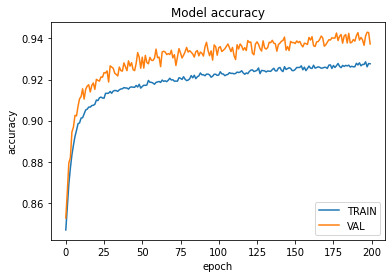

In [19]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

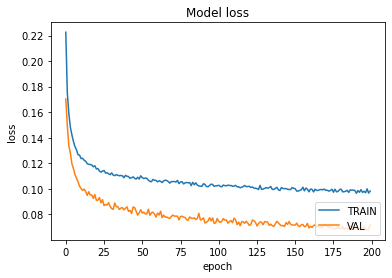

In [20]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [21]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

116/116 [==============================] - 0s 2ms/step - loss: 0.0713 - tp: 2392.0000 - fp: 46.0000 - tn: 18454.0000 - fn: 1308.0000 - accuracy: 0.9390 - precision: 0.9811 - recall: 0.6465 - auc: 0.9867 - prc: 0.9473


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88       532
           1       0.90      0.83      0.86       854
           2       0.90      0.73      0.81       484
           3       0.81      0.88      0.84       812
           4       0.76      0.99      0.86       504
           5       0.99      1.00      0.99       514

    accuracy                           0.87      3700
   macro avg       0.89      0.88      0.88      3700
weighted avg       0.88      0.87      0.87      3700



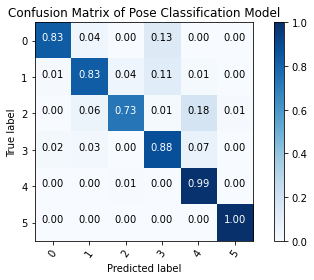

In [22]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [18]:
#Classes 3, 4 Need to be weighted

